## Colab Cells

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ugs-applications/

/content/drive/MyDrive/ugs-applications


## Instal Packages

In [3]:
!pip3 install transformer_lens
!pip3 install seaborn
!pip3 install fancy_einsum
!pip3 install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.3 MB/s eta 0:00:00
  Using cached nvid

## Imports

In [4]:
import torch
import numpy as np
from tqdm import tqdm
from fancy_einsum import einsum
import math
from functools import partial
import torch.optim
import time
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
from einops import repeat
from utils.circuit_utils import prune_dangling_edges, discretize_mask
from utils.training_utils import load_model_data
from utils.MaskConfig import VertexInferenceConfig
import argparse
import os
from utils.task_datasets import IOIConfig
from utils.task_datasets import get_task_ds
from utils.training_utils import load_model_data, LinePlot, update_means_variances_mixed, update_means_variances
from pruners.VertexPruner import VertexPruner
from mask_samplers.AblationMaskSampler import SingleComponentMaskSampler

In [5]:
try:
    parser = argparse.ArgumentParser()
    parser.add_argument('-s', '--subfolder',
                        help='where to save stuff')
    args = parser.parse_args()
    subfolder = args.subfolder
except:
    subfolder = None

if subfolder is not None:
    folder=f"atp/{subfolder}"
else:
    folder=f"atp/ioi"

if not os.path.exists(folder):
    os.makedirs(folder)

usage: colab_kernel_launcher.py [-h] [-s SUBFOLDER]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-b046e772-b258-48e0-99a1-4b025fcc4612.json


## Multi Component Sampler

In [ ]:
# for gradient sampling
class MultiComponentMaskSampler(torch.nn.Module):
    def __init__(self, pruning_cfg):
        super().__init__()

        self.sampled_mask = None

        self.use_temperature = False
        self.log_columns = []

        self.pruning_cfg = pruning_cfg

        self.n_layers = pruning_cfg.n_layers
        self.n_heads = pruning_cfg.n_heads
        self.device = pruning_cfg.device

        self.k = pruning_cfg.k

        self.mask_perturb = torch.nn.ParameterDict({
            "attn": torch.nn.ParameterList([
                torch.nn.Parameter(torch.zeros((self.n_heads,)).to(self.device))
                for i in range(self.n_layers)
            ]),
            "mlp": torch.nn.ParameterList([
                torch.nn.Parameter(torch.zeros((1,)).to(self.device))
                for i in range(self.n_layers)
            ])
        })

    def forward(self):
        bsz = self.pruning_cfg.batch_size * self.pruning_cfg.n_samples

        total_heads = self.n_layers * self.n_heads

        sampled_heads = self.k

        # select random subset
        ref_idx = torch.arange(bsz).unsqueeze(-1).repeat(1, sampled_heads)
        _, top_k_idx = torch.rand((bsz, total_heads)).topk(sampled_heads, dim=-1)

        attn_mask = torch.ones((bsz, total_heads)).to(self.device)
        attn_mask[ref_idx.flatten(), top_k_idx.flatten()] = 0

        attn_mask = attn_mask + (1-attn_mask) * (
            torch.rand_like(attn_mask).to(self.device) +
            torch.stack([param for param in self.mask_perturb['attn']], dim=0).flatten()
        )

        attn_mask = attn_mask.unflatten(1, (self.n_layers, -1))

        self.sampled_mask = {
            "attn": [
                attn_mask[:, i]
                for i in range(self.n_layers)
            ],
            "mlp": [
                torch.ones((bsz)).to(self.device)
                for i in range(self.n_layers)
            ]
        }
        return 0, {}

    def record_state(self, j):
        pass

## Run Multi Component Sampler

In [ ]:
def run_MCMS(ablation_type = "mean_agnostic",
              dataset = "ioi",
              n_samples = 1,
              batch_size = 100,
              model_name = "gpt2-small",
              owt_batch_size = 10,
              k = 1,
              max_batches = 10000,
              folder = "results/mcms"):

  if not os.path.exists(folder):
    print("Creating Folder", folder)
    os.makedirs(folder)

  # init model and tokenizer
  device, model, tokenizer, owt_iter = load_model_data(model_name, owt_batch_size)
  model.eval()
  n_layers = model.cfg.n_layers
  n_heads = model.cfg.n_heads

  # init pruning configs
  pruning_cfg = VertexInferenceConfig(model.cfg, device, folder, init_param=1)
  pruning_cfg.batch_size = batch_size
  pruning_cfg.n_samples = n_samples
  pruning_cfg.k = k
  print("---------------------------")
  print("Pruning Config")
  print("---------------------------")
  for k,v in pruning_cfg.__dict__.items():
    if k != "constant_prune_mask" and k!= "init_params":
      print(k,":",v)

  # init ds configs
  task_ds = get_task_ds(dataset, pruning_cfg.batch_size, device, ablation_type)

  for param in model.parameters():
      param.requires_grad = False
  print("---------------------------")
  print("Dataset Config")
  print("---------------------------")
  [print(k, ":", v) for k,v in task_ds.__dict__.items()]
  print("---------------------------")

  pruner_args = task_ds.get_pruner_args({"zero", "mean", "resample", "cf_mean", "cf", "oa", "oa_specific","mean_agnostic"})

  # init mask_sampler
  mask_sampler = MultiComponentMaskSampler(pruning_cfg)
  mask_sampler()
  print("Attn mask shape per layer", mask_sampler.sampled_mask["attn"][0].shape)
  print("MLP mask shape per layer", mask_sampler.sampled_mask["mlp"][0].shape)

  print("---------------------------")
  print("Starting Evaluation")
  print("---------------------------")

  # init vertex pruner
  vertex_pruner = VertexPruner(model, pruning_cfg, mask_sampler, **pruner_args)
  vertex_pruner.add_patching_hooks()
  vertex_pruner.modal_attention.requires_grad = False
  vertex_pruner.modal_mlp.requires_grad = False

  # init results variables
  sampling_optimizer = torch.optim.AdamW(mask_sampler.parameters(), lr=1, weight_decay=0)
  head_losses = torch.zeros((n_layers * n_heads,1)).to(device)
  head_vars = torch.zeros((n_layers * n_heads,1)).to(device)
  n_batches_by_head = torch.zeros_like(head_losses).to(device)
  n_samples_by_head = torch.zeros_like(head_losses).to(device)

  max_batches = int(max_batches / (batch_size * n_samples))


  for no_batches in tqdm(range(vertex_pruner.log.t, max_batches)):
      batch, last_token_pos,cf = task_ds.retrieve_batch_cf(tokenizer)
      last_token_pos = last_token_pos.int()

      sampling_optimizer.zero_grad()

      loss = vertex_pruner(batch, last_token_pos,timing = False, print_loss = False)
      loss.backward()

      atp_losses = torch.cat([ts.grad for ts in mask_sampler.mask_perturb['attn']], dim=0).unsqueeze(-1)

      batch_n_samples = []
      for ts in mask_sampler.sampled_mask['attn']:
          batch_n_samples.append((ts < 1-1e-3).sum(dim=0))
      batch_n_samples = torch.cat(batch_n_samples, dim=0).unsqueeze(-1)


      atp_losses = torch.where(
          batch_n_samples > 0,
          atp_losses / batch_n_samples * n_samples * batch_size,
          0
      )


      head_losses, head_vars, n_batches_by_head, n_samples_by_head = update_means_variances_mixed(head_losses, head_vars, atp_losses, n_batches_by_head, n_samples_by_head, batch_n_samples)
  print("---------------------------")
  print("Finished Evaluation")
  return head_losses, head_vars, n_batches_by_head, n_samples_by_head

In [ ]:
head_losses, head_vars, n_batches_by_head, n_samples_by_head = run_MCMS(k =40)

Loading model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loading OWT...
Loading OWT data from disk
Making DataLoader
---------------------------
Pruning Config
---------------------------
device : cuda:0
n_layers : 12
n_heads : 12
folder : results/mcms
lamb : None
record_every : 100
checkpoint_every : 5
starting_beta : 0.6666666666666666
hard_concrete_endpoints : (-0.1, 1.1)
layers_to_prune : [('attn', 0), ('mlp', 0), ('attn', 1), ('mlp', 1), ('attn', 2), ('mlp', 2), ('attn', 3), ('mlp', 3), ('attn', 4), ('mlp', 4), ('attn', 5), ('mlp', 5), ('attn', 6), ('mlp', 6), ('attn', 7), ('mlp', 7), ('attn', 8), ('mlp', 8), ('attn', 9), ('mlp', 9), ('attn', 10), ('mlp', 10), ('attn', 11), ('mlp', 11), ('mlp', 12)]
temp_min_reg : 0.001
temp_adj_intv : 10
temp_avg_intv : 20
temp_comp_intv : 200
temp_convergence_target : 2000
temp_c : 0
temp_momentum : 0
batch_size : 100
n_samples : 1
lr : 0.01
lr_modes : 0.002
k : 40
---------------------------
Dataset Config
---------------------------
ds_name :

100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


---------------------------
Finished Evaluation


In [ ]:
(single_component_head_losses[:144]/ head_losses).mean()

tensor(-0.2965, device='cuda:0')

In [8]:
ablation_type = "mean_agnostic"
dataset = "ioi"
n_samples = 1
batch_size = 32
model_name = "gpt2-small"
owt_batch_size = 10
k = 16

In [332]:
device, model, tokenizer, owt_iter = load_model_data(model_name, owt_batch_size)
model.eval()
# model.cfg.use_attn_result = True
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

pruning_cfg = VertexInferenceConfig(model.cfg, device, folder, init_param=1)
pruning_cfg.batch_size = batch_size
pruning_cfg.n_samples = n_samples
pruning_cfg.k = k

task_ds = get_task_ds(dataset, pruning_cfg.batch_size, device, ablation_type)

for param in model.parameters():
    param.requires_grad = False

print("Dataset Config", task_ds.__dict__)

pruner_args = task_ds.get_pruner_args({"zero", "mean", "resample", "cf_mean", "cf", "oa", "oa_specific","mean_agnostic"})

mask_sampler = MultiComponentMaskSampler(pruning_cfg)

mask_sampler()
print("Attn mask shape per layer", mask_sampler.sampled_mask["attn"][0].shape)
print("MLP mask shape per layer", mask_sampler.sampled_mask["mlp"][0].shape)

vertex_pruner = VertexPruner(model, pruning_cfg, mask_sampler, **pruner_args)
vertex_pruner.add_patching_hooks()

vertex_pruner.modal_attention.requires_grad = False
vertex_pruner.modal_mlp.requires_grad = False

Loading model...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer
Loading OWT...
Loading OWT data from disk
Making DataLoader
Dataset Config {'ds_name': 'ioi', 'batch_size': 32, 'device': device(type='cuda', index=0), 'ablation_type': 'mean_agnostic', 'means': None, 'ds': <list_iterator object at 0x780f9687d990>, 'seed': 0, 'fix_prompt': False}
Attn mask shape per layer torch.Size([32, 12])
MLP mask shape per layer torch.Size([32])


In [380]:
sampling_optimizer = torch.optim.AdamW(mask_sampler.parameters(), lr=1, weight_decay=0)
head_losses = torch.zeros((n_layers * n_heads,1)).to(device)
head_vars = torch.zeros((n_layers * n_heads,1)).to(device)
n_batches_by_head = torch.zeros_like(head_losses).to(device)
n_samples_by_head = torch.zeros_like(head_losses).to(device)

high_losses = torch.zeros((1,)).to(device)

max_batches = int(10000 / (batch_size * n_samples))


for no_batches in tqdm(range(vertex_pruner.log.t, max_batches)):
    batch, last_token_pos,cf = task_ds.retrieve_batch_cf(tokenizer)
    last_token_pos = last_token_pos.int()

    sampling_optimizer.zero_grad()

    loss = vertex_pruner(batch, last_token_pos,timing = False, print_loss = False)
    loss.backward()

    atp_losses = torch.cat([ts.grad for ts in mask_sampler.mask_perturb['attn']], dim=0).unsqueeze(-1)


    batch_n_samples = []
    for ts in mask_sampler.sampled_mask['attn']:
        batch_n_samples.append((ts < 1-1e-3).sum(dim=0))
    batch_n_samples = torch.cat(batch_n_samples, dim=0).unsqueeze(-1)


    atp_losses = torch.where(
        batch_n_samples > 0,
        atp_losses / batch_n_samples * n_samples * batch_size,
        0
    )
    break


    head_losses, head_vars, n_batches_by_head, n_samples_by_head = update_means_variances_mixed(head_losses, head_vars, atp_losses, n_batches_by_head, n_samples_by_head, batch_n_samples)

    # if no_batches % -100 == -1:
    #     sns.scatterplot(
    #         x=head_losses.cpu().flatten(),
    #         y=head_vars.sqrt().cpu().flatten()
    #     )
    #     plt.xlabel("attention head mean loss")
    #     plt.ylabel("attention head std loss")
    #     plt.show()


  0%|          | 0/294 [00:00<?, ?it/s]


In [334]:
batch_n_samples.sum()

tensor(2303, device='cuda:0')

In [381]:
(atp_losses/single_component_head_losses[:144]).mean()

tensor(-2.2753, device='cuda:0')

In [ ]:
batch_n_samples.sum()

tensor(2557, device='cuda:0')

In [362]:
( head_losses/single_component_head_losses[:144]).mean()

tensor(0., device='cuda:0')

In [340]:
single_component_head_vars.mean()

tensor(0.0253, device='cuda:0')

In [338]:
head_vars.mean()

tensor(0.0152, device='cuda:0')

In [ ]:
n_samples_by_head

tensor([[ 99.],
        [109.],
        [ 98.],
        [101.],
        [101.],
        [110.],
        [106.],
        [ 94.],
        [102.],
        [ 95.],
        [ 83.],
        [ 92.],
        [ 93.],
        [106.],
        [ 99.],
        [ 88.],
        [102.],
        [ 88.],
        [ 97.],
        [ 96.],
        [ 97.],
        [ 94.],
        [ 97.],
        [102.],
        [ 92.],
        [ 92.],
        [ 85.],
        [ 94.],
        [ 80.],
        [100.],
        [102.],
        [ 88.],
        [103.],
        [ 86.],
        [102.],
        [100.],
        [101.],
        [102.],
        [ 94.],
        [ 88.],
        [ 86.],
        [107.],
        [ 94.],
        [ 90.],
        [ 99.],
        [ 95.],
        [109.],
        [110.],
        [ 91.],
        [104.],
        [108.],
        [ 88.],
        [101.],
        [105.],
        [ 88.],
        [103.],
        [ 98.],
        [ 83.],
        [ 95.],
        [ 94.],
        [ 94.],
        [108.],
        

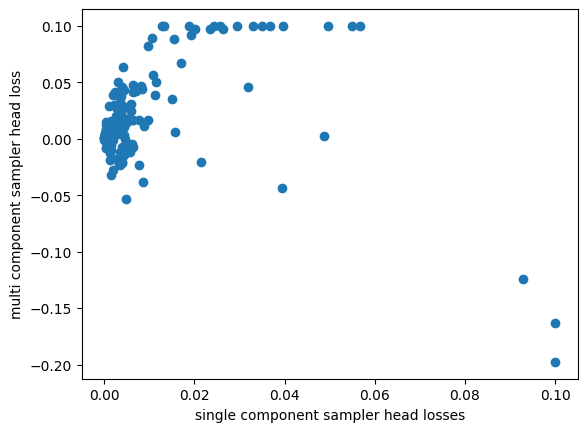

In [ ]:
from sklearn.metrics import r2_score

single_component_head_losses = pickle.load(open(folder + "/single_component_head_losses.pkl", "rb"))
single_component_head_vars = pickle.load(open(folder + "/single_component_head_vars.pkl", "rb"))


plt.scatter(single_component_head_losses[:144].cpu().clip(max=0.1), (head_losses.cpu() * -1).clip(max=0.1))


plt.xlabel('single component sampler head losses')
plt.ylabel('multi component sampler head loss')
plt.show()

In [ ]:
with open(folder + "/multi_component_head_losses.pkl", "wb") as f:
    pickle.dump(head_losses, f)
with open(folder + "/multi_component_head_vars.pkl", "wb") as f:
    pickle.dump(head_vars, f)

In [ ]:
r2_score(single_component_head_losses.cpu()[:144], (head_losses.cpu() * -1))

-4.295524686992042

## Run Single Component Sampler

In [9]:
model_name = "gpt2-small"
owt_batch_size = 10
device, model, tokenizer, owt_iter = load_model_data(model_name, owt_batch_size)
model.eval()
# model.cfg.use_attn_result = True
n_layers = model.cfg.n_layers
n_heads = model.cfg.n_heads

for param in model.parameters():
    param.requires_grad = False

pruning_cfg = VertexInferenceConfig(model.cfg, device, folder, init_param=1)

pruning_cfg.batch_size = 10


mask_sampler = SingleComponentMaskSampler(pruning_cfg)
pruning_cfg.n_samples = mask_sampler.n_components

print("Attn mask shape per layer", mask_sampler.sampled_mask["attn"][0].shape)
print("MLP mask shape per layer", mask_sampler.sampled_mask["mlp"][0].shape)


task_ds = get_task_ds(dataset, pruning_cfg.batch_size, device, ablation_type)

pruner_args = task_ds.get_pruner_args({"zero", "mean", "resample", "cf_mean", "cf", "oa", "oa_specific","mean_agnostic"})

vertex_pruner = VertexPruner(model, pruning_cfg, mask_sampler, **pruner_args)
vertex_pruner.add_patching_hooks()

Loading model...
Loaded pretrained model gpt2-small into HookedTransformer
Loading OWT...
Loading OWT data from disk
Making DataLoader
Attn mask shape per layer torch.Size([1560, 12])
MLP mask shape per layer torch.Size([1560])


In [11]:
max_batches = 100000 // pruning_cfg.batch_size
single_component_head_losses = torch.zeros((pruning_cfg.n_samples,1)).to(device)
single_component_head_vars = torch.zeros((pruning_cfg.n_samples,1)).to(device)

In [ ]:
for no_batches in tqdm(range(max_batches)):
    batch, last_token_pos, cf = task_ds.retrieve_batch_cf(tokenizer)

    with torch.no_grad():
        # loss: [n_components, batch_size]
        loss, _ = vertex_pruner(batch, last_token_pos, counterfactual=cf, separate_loss=True,timing = False, print_loss = False)
        single_component_head_losses, single_component_head_vars = update_means_variances(single_component_head_losses, single_component_head_vars, loss, no_batches)



  3%|▎         | 337/10000 [02:57<1:20:38,  2.00it/s]

In [ ]:
with open("single_component_head_losses.pkl", "wb") as f:
    pickle.dump(single_component_head_losses, f)
with open("single_component_head_vars.pkl", "wb") as f:
    pickle.dump(single_component_head_vars, f)

In [ ]:
single_component_head_losses

torch.Size([156, 1])

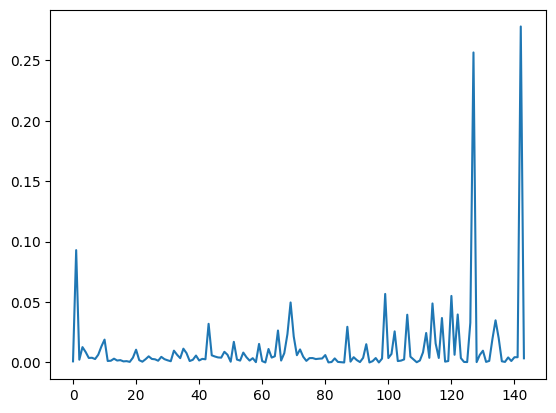

In [ ]:
single_component_head_losses_without_outlier = single_component_head_losses[:144][single_component_head_vars[:144] < .1]
plt.plot(np.arange(len(single_component_head_losses_without_outlier)), single_component_head_losses_without_outlier.cpu().numpy())
plt.show()

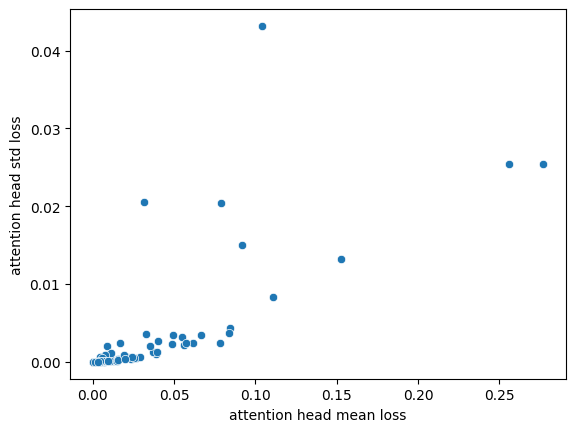

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Remove the outlier from single_component_head_vars
single_component_head_vars_without_outlier = single_component_head_vars[single_component_head_vars < 1]
single_component_head_losses_without_outlier = single_component_head_losses[single_component_head_vars < 1]
# Plot single_component_head_vars_without_outlier against single_component_head_losses
sns.scatterplot(
    x=single_component_head_losses_without_outlier.cpu().flatten(),
    y=single_component_head_vars_without_outlier.cpu().flatten()
)

plt.xlabel("attention head mean loss")
plt.ylabel("attention head std loss")
plt.show()


In [ ]:
single_component_head_losses[0]

tensor([0.0009], device='cuda:0')

In [ ]:
loss.shape

torch.Size([156, 1])

In [ ]:
mask_sampler.sampled_mask